<a href="https://colab.research.google.com/github/mounika-0124/Fake_News_Detection/blob/main/fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline


In [5]:
fake = pd.read_csv("/content/Fake.csv")
true = pd.read_csv("/content/True.csv")

In [6]:
fake.shape

(23481, 4)

In [7]:
true.shape

(21417, 4)

In [8]:
fake['target'] = 'fake'
true['target'] = 'true'

In [9]:
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [10]:
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [11]:
data.head()

,title,text,subject,date,target
0,Texas Republican Introduces Bill To Put Women...,Women in Texas may have to literally fight for...,News,"January 24, 2017",fake
1,NEW DISCOVERY REVEALS BALTIMORE STATE’S ATTORN...,Baltimore City State s Attorney Marilyn Mosby ...,politics,"Jul 15, 2015",fake
2,MN Taxpayers To Pay Rent For African Refugees ...,We re just wondering if the state of MN has ev...,politics,"Oct 1, 2016",fake
3,Military Veterans HUMILIATE Trump For Attacki...,Donald Trump just pissed off veterans.Trump li...,News,"August 7, 2017",fake
4,Republican senator: Tax plan needs more relief...,WASHINGTON (Reuters) - A Republican senator wh...,politicsNews,"November 16, 2017",true


In [12]:
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Texas Republican Introduces Bill To Put Women...,Women in Texas may have to literally fight for...,News,fake
1,NEW DISCOVERY REVEALS BALTIMORE STATE’S ATTORN...,Baltimore City State s Attorney Marilyn Mosby ...,politics,fake
2,MN Taxpayers To Pay Rent For African Refugees ...,We re just wondering if the state of MN has ev...,politics,fake
3,Military Veterans HUMILIATE Trump For Attacki...,Donald Trump just pissed off veterans.Trump li...,News,fake
4,Republican senator: Tax plan needs more relief...,WASHINGTON (Reuters) - A Republican senator wh...,politicsNews,true


In [13]:
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,Women in Texas may have to literally fight for...,News,fake
1,Baltimore City State s Attorney Marilyn Mosby ...,politics,fake
2,We re just wondering if the state of MN has ev...,politics,fake
3,Donald Trump just pissed off veterans.Trump li...,News,fake
4,WASHINGTON (Reuters) - A Republican senator wh...,politicsNews,true


In [14]:
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,women in texas may have to literally fight for...,News,fake
1,baltimore city state s attorney marilyn mosby ...,politics,fake
2,we re just wondering if the state of mn has ev...,politics,fake
3,donald trump just pissed off veterans.trump li...,News,fake
4,washington (reuters) - a republican senator wh...,politicsNews,true


In [15]:
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [16]:
data.head()

,text,subject,target
0,women in texas may have to literally fight for...,News,fake
1,baltimore city state s attorney marilyn mosby ...,politics,fake
2,we re just wondering if the state of mn has ev...,politics,fake
3,donald trump just pissed off veteranstrump lik...,News,fake
4,washington reuters a republican senator who h...,politicsNews,true


In [17]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
data.head()

,text,subject,target
0,women texas may literally fight freedom lives ...,News,fake
1,baltimore city state attorney marilyn mosby te...,politics,fake
2,wondering state mn ever considered giving us v...,politics,fake
3,donald trump pissed veteranstrump likes claim ...,News,fake
4,washington reuters republican senator publicly...,politicsNews,true


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


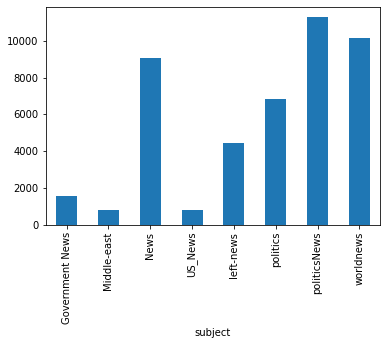

In [19]:
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


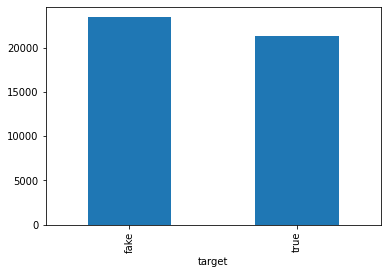

In [20]:
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [21]:
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

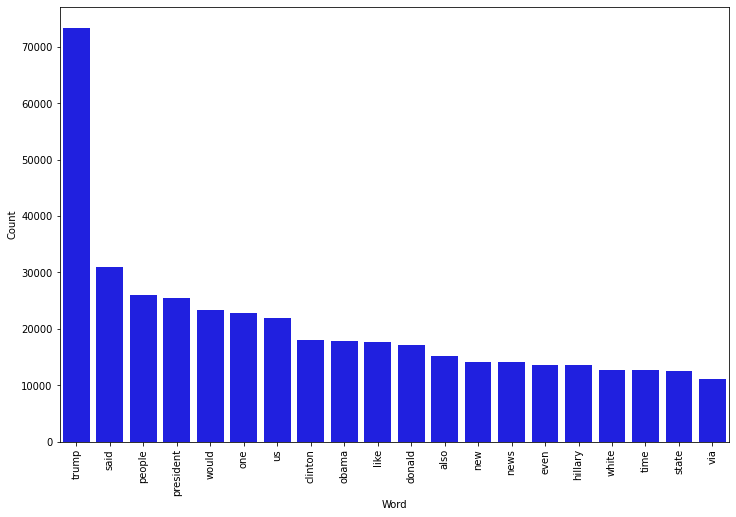

In [22]:
counter(data[data["target"] == "fake"], "text", 20)

In [23]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [25]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.51%


In [26]:
import sklearn.metrics as metrics

Confusion matrix, without normalization


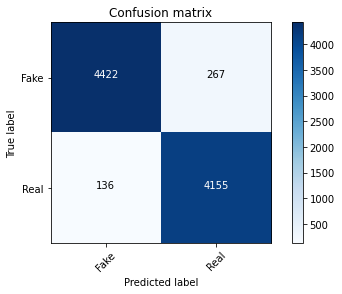

In [27]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [28]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.09%


Confusion matrix, without normalization


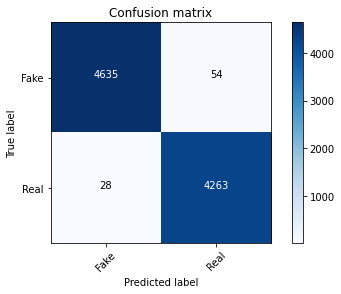

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [30]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 98.94%


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

In [ ]:
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)